This model takes windows of assignment grades as input output a onehot vector of size 4 which indicates whether the student completed the assignment, missed the assignment, dropping CSCA08 or already dropped CSCA08 previously.(i.e. [1,0,0,0] indicates that the student completed the assignment) The accuracy score is around 0.842, and 0.427 for f1 score.


In [ ]:
import torch
import torch.nn as nn
from torch import nn,optim
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import os
import random
import copy
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,recall_score,precision_score,roc_curve,roc_auc_score,accuracy_score,confusion_matrix,r2_score
from sklearn.metrics import r2_score, mean_squared_error
import torch.nn.functional as F
from abc import ABC
import torch.utils.data as Data

from sklearn.preprocessing import StandardScaler
import os ,re
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df = pd.read_excel('2015-2017 CSCA08 Student Data.xlsx')
df

,Year,Id,UTorID,Type,Gender,Gender2,Exe0,Exe1,Exe2,Exe3,...,TT1,TT2,EX,EX.1,FinalGrade,Status,DropTime,PartialGrade,Assignment Partial,Mid Term Partial
0,2015,9.902906e+08,dcostaad,Domestic,MR,Male,1.0,1.000000,0.818182,1.000000,...,0.816667,0.800000,0.67,0.67,0.774253,Complete,NaN,0.868835,0.908310,0.808333
1,2015,9.982007e+08,wangjunq,International,MR,Male,0.0,1.000000,0.909091,1.000000,...,0.566667,0.466667,0.43,0.43,0.559584,Complete,NaN,0.641919,0.776137,0.516667
2,2015,9.983004e+08,xuzheng,Domestic,MR,Male,1.0,1.000000,0.818182,1.000000,...,0.658333,0.733333,0.56,0.56,0.657379,Complete,NaN,0.812951,0.914187,0.695833
3,2015,9.983261e+08,leehyu37,International,MR,Male,1.0,0.666667,0.818182,0.916667,...,0.583333,0.866667,0.84,0.84,0.837111,Complete,NaN,0.801598,0.863400,0.725000
4,2015,9.984079e+08,khanmu31,Domestic,MR,Male,0.0,1.000000,0.545455,1.000000,...,0.541667,0.400000,0.37,0.37,0.394412,Complete,NaN,0.552943,0.775221,0.470833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2363,2017,1.004574e+09,zhanjenk,Domestic,NaN,NaN,1.0,1.000000,0.714000,0.737000,...,NaN,NaN,NaN,NaN,NaN,EX5,before,NaN,NaN,NaN
2364,2017,1.003323e+09,zhaodav3,Domestic,MR,Male,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,EX1,before,NaN,NaN,NaN
2365,2017,1.003779e+09,zhaoyu79,International,MS,Female,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,EX1,before,NaN,NaN,NaN
2366,2017,1.003557e+09,zhouwe42,International,MISS,Female,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,EX1,before,NaN,NaN,NaN


In [ ]:
event_sequence = ['Exe0', 'Exe1', 'TT1', 'Exe2', 'Exe3', 'A1', 'Exe4', 'Exe5', 'Exe6', 'TT2', 'Exe7', 'A2', 'Exe8', 'Exe9', 'Exe10', 'A3', 'EX']
df1 = df[event_sequence]
df1 = df1.fillna(0)
df1

,Exe0,Exe1,TT1,Exe2,Exe3,A1,Exe4,Exe5,Exe6,TT2,Exe7,A2,Exe8,Exe9,Exe10,A3,EX
0,1.0,1.000000,0.816667,0.818182,1.000000,0.860714,1.000000,1.0,1.000000,0.800000,1.0,0.942308,0.909091,1.000000,0.666667,0.737500,0.67
1,0.0,1.000000,0.566667,0.909091,1.000000,0.767857,0.933333,1.0,0.545455,0.466667,0.0,0.782051,0.818182,0.941176,0.500000,0.579167,0.43
2,1.0,1.000000,0.658333,0.818182,1.000000,0.910714,1.000000,1.0,1.000000,0.733333,1.0,0.916667,0.545455,0.764706,0.000000,0.200000,0.56
3,1.0,0.666667,0.583333,0.818182,0.916667,0.878571,1.000000,1.0,1.000000,0.866667,1.0,0.852564,0.363636,1.000000,0.000000,0.816667,0.84
4,0.0,1.000000,0.541667,0.545455,1.000000,0.846429,0.000000,0.3,0.000000,0.400000,0.0,0.724359,0.181818,0.000000,0.000000,0.187500,0.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2363,1.0,1.000000,0.000000,0.714000,0.737000,0.344000,0.938000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
2364,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
2365,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
2366,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00


In [ ]:
g = torch.where(torch.tensor(df1.values) > 0, 1, 0).tolist()
for i in range(len(g)):
  if 1 in g[i]:
    drop = len(g[i]) - g[i][::-1].index(1)
    for j in range(len(g[i])):
      if j < drop:
        g[i][j] = [1,0,0,0] if g[i][j] == 1 else [0,1,0,0]
      elif j == drop:
        g[i][j] = [0,0,1,0]
      else:
        g[i][j] = [0,0,0,1]
  else:
    g[i] = [[0,0,0,1] for j in range(len(g[i]))]
g = torch.Tensor(g)
g = g.detach().numpy()
g.shape

(2368, 17, 4)

In [ ]:
history_size = 4
target_size = 1
x = []
y = []
data = df1.values
for j in range(len(df1)):
  for i in range(data.shape[1] - history_size):
    x.append(data[j][i:i+history_size])
    y.append(g[j][i+history_size:i+history_size+target_size])

x = np.array(x)
x = x.reshape([x.shape[0], x.shape[1], 1])
y = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=90)

x_train = torch.tensor(x_train, dtype=torch.float)
x_test = torch.tensor(x_test, dtype=torch.float)

y_train = torch.tensor(y_train, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

b1 = int(len(x_train)/15)
b2 = int(len(x_test)/15)

train_loader = Data.DataLoader(
  dataset=Data.TensorDataset(x_train, y_train),
  batch_size=b1,
  shuffle=True,
  drop_last=True,
  num_workers=0,
) 
test_loader = Data.DataLoader(
  dataset=Data.TensorDataset(x_train, y_train),
  batch_size=b2,
  shuffle=True,
  drop_last=True,
  num_workers=0,
)

y_test = y_test.detach().numpy()
y_train = y_train.detach().numpy()


In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([24627, 4, 1]),
 torch.Size([6157, 4, 1]),
 (24627, 1, 4),
 (6157, 1, 4))

In [ ]:
class LSTM(nn.Module):
  def __init__(self,p,input_size, output_size, hidden_layer_size):
      super().__init__()
      self.hidden_layer_size = hidden_layer_size
      self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
      self.linear1 = nn.Linear(hidden_layer_size*4, output_size)
      self.dropout = nn.Dropout(p=p)
      self.tanh = nn.Tanh()
      self.sigmoid = nn.Sigmoid()
      self.softmax = nn.Softmax(dim=1)
  def forward(self, input_x):
      lstm_out, _ = self.lstm(input_x)
#      lstm_out = self.dropout(lstm_out)
      linear_out1 = self.linear1(lstm_out.reshape(len(input_x),-1))
      linear_out1 = self.softmax(linear_out1)
      linear_out1 = torch.squeeze(linear_out1)
      return linear_out1

In [ ]:
def softmax_onehot(props):
  assert(isinstance(props, list))
  props = np.array(props)
  a = np.argmax(props, axis=1)
  output = np.zeros((len(a), props.shape[1]))
  output[np.arange(len(a)), a] = 1
  return output

In [ ]:
p = 0
l = 0.0003
hidden_size = 16
input_size = 1
output_size = 4
Epochs = 200
model = LSTM(p, input_size, output_size, hidden_size)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=l)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.95)
result = {}
result['train-f1'] = []
result['test-f1'] = []
result['train-loss'] = []
result['test-loss'] = []
result['train-acc'] = []
result['test-acc'] = []

F1 = 0
Len_train = len(train_loader)
for epochs in range(Epochs):
  loss_mean_train = 0
  loss_mean_test = 0
  acc_train = 0
  acc_test = 0
  f1_train = 0
  f1_test = 0
  model.train()
  for data_l in train_loader:
    seq, labels = data_l
    # print(labels)
    optimizer.zero_grad()
    y_pred = model(seq)
    labels = torch.squeeze(labels)
    single_loss = loss_function(y_pred, labels)
    loss_mean_train += single_loss.item()
    single_loss.backward()
    optimizer.step()
    # print(labels.numpy())
    # print(softmax_onehot(y_pred.detach().tolist()))
    f1 = f1_score(labels.numpy(), softmax_onehot(y_pred.detach().tolist()), average='macro')
    f1_train += f1
    acc = accuracy_score(labels.numpy(), softmax_onehot(y_pred.detach().tolist()))
    acc_train += acc

  scheduler.step()
  loss_mean_train = loss_mean_train/Len_train
  f1_train = f1_train/Len_train
  acc_train = acc_train/Len_train
  result['train-loss'].append(loss_mean_train)
  result['train-acc'].append(acc_train)
  result['train-f1'].append(f1_train)

  model.eval()
  y_predict = model(x_test)
  loss_mean_test = loss_function(y_predict, torch.squeeze(torch.tensor(y_test,dtype=torch.float))).item()
  y_predict = y_predict.detach().numpy()
  y_test = torch.squeeze(torch.tensor(y_test, dtype=torch.float)).numpy()
  # auc_test = roc_auc_score(y_test, y_predict)
  f1_test = f1_score(y_test, softmax_onehot(y_predict.tolist()), average='macro')
  acc_test = accuracy_score(y_test, softmax_onehot(y_predict.tolist()))
  result['test-loss'].append(loss_mean_test)
  result['test-acc'].append(acc_test)
  result['test-f1'].append(f1_test)
  print('Epochs',epochs,'loss_train',round(loss_mean_train,4),'loss_test',round(loss_mean_test,4),'acc_train:',round(acc_train,3),'acc_test',round(acc_test,3),'f1_train:',round(f1_train,3),'f1_test:',round(f1_test,3))
  if F1 < f1_test:
      F1 =f1_test
      torch.save(model, 'model_LSTM3.pth')
      print('Update model')

Epochs 0 loss_train 1.3868 loss_test 1.3817 acc_train: 0.014 acc_test 0.087 f1_train: 0.007 f1_test: 0.051
Update model
Epochs 1 loss_train 1.3772 loss_test 1.3716 acc_train: 0.611 acc_test 0.743 f1_train: 0.199 f1_test: 0.213
Update model
Epochs 2 loss_train 1.3667 loss_test 1.3603 acc_train: 0.738 acc_test 0.743 f1_train: 0.212 f1_test: 0.213
Epochs 3 loss_train 1.3547 loss_test 1.3471 acc_train: 0.738 acc_test 0.743 f1_train: 0.212 f1_test: 0.213
Epochs 4 loss_train 1.3404 loss_test 1.3311 acc_train: 0.738 acc_test 0.743 f1_train: 0.212 f1_test: 0.213
Epochs 5 loss_train 1.323 loss_test 1.3114 acc_train: 0.738 acc_test 0.743 f1_train: 0.212 f1_test: 0.213
Epochs 6 loss_train 1.3012 loss_test 1.2866 acc_train: 0.738 acc_test 0.743 f1_train: 0.212 f1_test: 0.213
Epochs 7 loss_train 1.2738 loss_test 1.2553 acc_train: 0.738 acc_test 0.743 f1_train: 0.212 f1_test: 0.213
Epochs 8 loss_train 1.2396 loss_test 1.2172 acc_train: 0.738 acc_test 0.743 f1_train: 0.212 f1_test: 0.213
Epochs 9 los

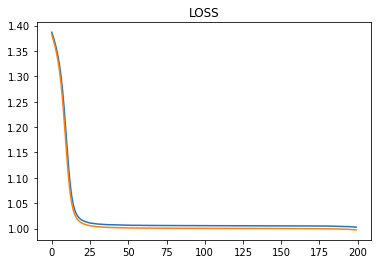

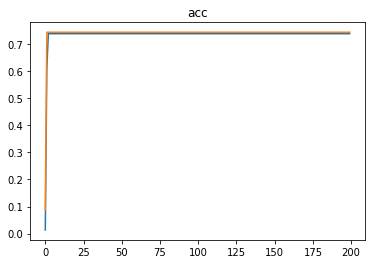

In [ ]:
import matplotlib.pyplot as plt
plt.plot(result['train-loss'][:],label='Loss_train')
plt.plot(result['test-loss'][:],label='Loss_test')
plt.title('LOSS')
# plt.savefig('loss_1bu1.png',dpi = 500)
plt.show()

import matplotlib.pyplot as plt
plt.plot(result['train-acc'][:],label='train_acc')
plt.plot(result['test-acc'][:],label='test_acc')
plt.title('acc')
# plt.savefig('loss_1bu1.png',dpi = 500)
plt.show()

Prepare data

In [ ]:

xx = [0.0,	1.000000,	0.1,	0.0]
xx = torch.tensor(xx,dtype = torch.float)
xx = xx.reshape(1,4,1)
xx.shape

torch.Size([1, 4, 1])

Load model

In [ ]:
model = torch.load('model_LSTM3.pth')

Predict

In [ ]:
y_pre = model(xx)
torch.argmax(y_pre)

tensor(0)